# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [2]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = 1, output channels = 6, kernel size = 5
    # input image size = (32, 32), image output size = (28, 28)
    self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)

    # input channel = 6, output channels = 16, kernel size = 5
    # input image size = (14, 14), output image size = (10, 10)
    self.conv2 = torch.nn.Conv2d(6, 16, 5)

    # input dim = 16*5*5 ( H x W x C), output dim = 120
    self.fc1 = torch.nn.Linear(16*5*5, 120)    

    # input dim = 120, output dim = 84
    self.fc2 = torch.nn.Linear(120, 84)

    # input dim = 84, output dim = 10
    self.output = torch.nn.Linear(84, 10)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    # Max Pooling with kernel size = 2
    # output size = (14, 14)
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv2(x))
    # Max Pooling with kernel size = 2
    # output size = (5, 5)
    x = F.max_pool2d(x, 2, 2)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    

    x = F.relu(self.fc1(x))

    x = F.relu(self.fc2(x))
    
    x = F.softmax(self.output(x), dim=1)

    return x

### Define cost function

In [3]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [4]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [5]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer
    optimizer.zero_grad()
  
    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [6]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  path = '../MLP/data'
  full_training_data = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST(path, train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [7]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(net,
         batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):

  train_loader, val_loader, test_loader = get_data(batch_size)

  net = net.to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [8]:
net = LeNet()
main(net)

Before training:
	 Training loss 0.01804, Training accuracy 9.06
	 Validation loss 0.00906, Validation accuracy 9.01
	 Test loss 0.00921, Test accuracy 8.92
-----------------------------------------------------


c:\Users\ronan\Documents\Telecom\2A\SD\SD-TSIA203\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1
	 Training loss 0.01803, Training accuracy 15.19
	 Validation loss 0.00905, Validation accuracy 22.36
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01800, Training accuracy 16.93
	 Validation loss 0.00901, Validation accuracy 13.27
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01615, Training accuracy 39.84
	 Validation loss 0.00692, Validation accuracy 72.44
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01326, Training accuracy 77.69
	 Validation loss 0.00649, Validation accuracy 81.59
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01272, Training accuracy 84.17
	 Validation loss 0.00634, Validation accuracy 85.45
-----------------------------------------------------
Epoch: 6
	 Training loss 0.01258, Training accuracy 85.89
	 Validation loss 0.00630, Validation accuracy 86.13
-----------------------------------------------------
Epoch: 7
	

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
def get_confusion_matrix(net, data_loader, device='cuda:0'):
  net.eval()
  y_true = list()
  y_pred = list()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      _, predicted = outputs.max(1)
      y_true.extend(targets.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

  return confusion_matrix(y_true, y_pred)

<Axes: >

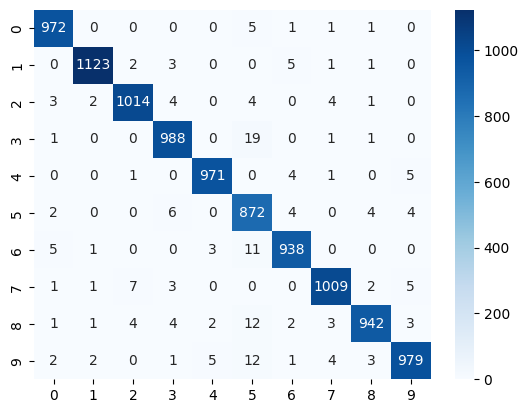

In [12]:
conf = get_confusion_matrix(net, get_data(128)[2])
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

The most confused digits are 3 and 5, 5 and 6, 5 and 8, 5 and 9.
This is due to the fact these digits have similar curves.

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [13]:
net2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, 5, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(6, 16, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(),
    torch.nn.Linear(16*5*5, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10),
    torch.nn.Softmax(dim=1)
)

main(net2)

Before training:
	 Training loss 0.01803, Training accuracy 10.12
	 Validation loss 0.00906, Validation accuracy 10.32
	 Test loss 0.00921, Test accuracy 10.10
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01803, Training accuracy 10.14
	 Validation loss 0.00905, Validation accuracy 10.53
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01801, Training accuracy 21.24
	 Validation loss 0.00903, Validation accuracy 31.06
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01740, Training accuracy 32.79
	 Validation loss 0.00784, Validation accuracy 47.38
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01373, Training accuracy 73.26
	 Validation loss 0.00644, Validation accuracy 83.30
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01269, Training accuracy 84.65
	 Validation loss 0.00632, Validation accuracy 85.99
---------------

In [14]:
torch.save(net2.state_dict(), 'lenet.pth')

<Axes: >

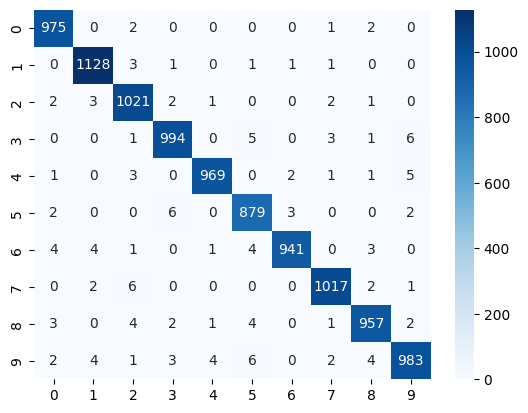

In [15]:
conf = get_confusion_matrix(net2, get_data(128)[2])
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

## Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.





In [16]:
def main_with_early_stop(net,
                         K,
                         batch_size=128,
                         device='cuda:0',
                         learning_rate=0.01,
                         weight_decay=0.000001,
                         momentum=0.9,
                         epochs=50):

  val_losses = list()
  train_loader, val_loader, test_loader = get_data(batch_size)

  net = net.to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    val_losses.append(val_loss)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
    if len(val_losses) > K:
        if val_losses[-K] <= val_losses[-1]:
            break

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [27]:
net3 = LeNet()
main_with_early_stop(net3, 5, epochs=75)

Before training:
	 Training loss 0.01804, Training accuracy 9.70
	 Validation loss 0.00906, Validation accuracy 10.17
	 Test loss 0.00921, Test accuracy 10.36
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01803, Training accuracy 12.77
	 Validation loss 0.00905, Validation accuracy 16.78
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01801, Training accuracy 23.38
	 Validation loss 0.00903, Validation accuracy 38.69
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01702, Training accuracy 34.90
	 Validation loss 0.00721, Validation accuracy 64.11
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01360, Training accuracy 73.26
	 Validation loss 0.00672, Validation accuracy 75.45
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01297, Training accuracy 81.09
	 Validation loss 0.00636, Validation accuracy 84.85
----------------

## Resnet18

In [30]:
def get_data_rgb(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform.append(T.Lambda(lambda x: x.repeat(3, 1, 1)))
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  path = '../MLP/data'
  full_training_data = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST(path, train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [32]:
def main_rgb(net,
         batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):

  train_loader, val_loader, test_loader = get_data_rgb(batch_size)

  net = net.to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [33]:
resnet18 = torchvision.models.resnet18()
main_rgb(resnet18)
conf = get_confusion_matrix(resnet18, get_data_rgb(128)[2])
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

Before training:


c:\Users\ronan\Documents\Telecom\2A\SD\SD-TSIA203\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


	 Training loss 0.05401, Training accuracy 0.00
	 Validation loss 0.02712, Validation accuracy 0.00
	 Test loss 0.02758, Test accuracy 0.00
-----------------------------------------------------


c:\Users\ronan\Documents\Telecom\2A\SD\SD-TSIA203\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1
	 Training loss 0.00206, Training accuracy 93.68
	 Validation loss 0.00025, Validation accuracy 98.17
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00036, Training accuracy 98.53
	 Validation loss 0.00027, Validation accuracy 97.87
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00024, Training accuracy 99.03
	 Validation loss 0.00020, Validation accuracy 98.60
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00016, Training accuracy 99.27
	 Validation loss 0.00017, Validation accuracy 98.68
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00010, Training accuracy 99.60
	 Validation loss 0.00019, Validation accuracy 98.65
-----------------------------------------------------
Epoch: 6
	 Training loss 0.00005, Training accuracy 99.82
	 Validation loss 0.00018, Validation accuracy 98.74
-----------------------------------------------------
Epoch: 7
	

KeyboardInterrupt: 